
### SHAP

In [1]:
import os
import shap
import torch
import random
import numpy as np

import NEXUS
from NEXUS.model_int.SHAP_VAE.shap_explainer import shap_nexus
from NEXUS.cell_emb.model import OneViewVAE, TwoViewVAE, EncoderOnly

In [2]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

In [3]:
input_path = '../test_data/1_cell_emb_output/'
input_adata_path = input_path + "/VAE_embedded.h5ad"
input_model_param_path = input_path + "/VAE.pth"
output_path = '../test_data/3_SHAP_output/'

if not os.path.exists(output_path):
    os.makedirs(output_path)

In [4]:
num_of_highly_variable_genes = 5579
cell_embedding_dim = 64
model = OneViewVAE(num_of_highly_variable_genes, cell_embedding_dim)

In [5]:
checkpoint = torch.load(input_model_param_path, map_location=torch.device('cpu'), weights_only=False)
model.load_state_dict(checkpoint.state_dict())

<All keys matched successfully>

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_encoder = EncoderOnly(model, 'oneview').to(device)

In [7]:
shap_nexus(model_encoder, input_adata_path, output_path, device, cell_num=500)

F:\Anaconda\envs\NEXUS\lib\site-packages\shap\explainers\_deep\deep_pytorch.py:255: UserWarning: unrecognized nn.Module: LayerNorm
  warnings.warn(f"unrecognized nn.Module: {module_type}")


In [8]:
import scanpy as sc
from NEXUS.model_int.SHAP_VAE.shap_explainer import plot_rank_genes_as_bar

In [9]:
adata = sc.read_h5ad('../test_data/2_graph_emb_output/cell_embedded_adata.h5ad')

F:\Anaconda\envs\NEXUS\lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [10]:
sc.tl.rank_genes_groups(
    adata, 
    groupby='cell_type',
    method='wilcoxon',
    n_genes=20,
    key_added='rank_genes'
)

F:\Anaconda\envs\NEXUS\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
F:\Anaconda\envs\NEXUS\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
F:\Anaconda\envs\NEXUS\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
F:\Anaconda\envs\NEXUS\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
F:\Anaconda\envs\NEXUS\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
F:\Anaconda\envs\NEXUS\lib\site-packages\scanpy\tools\_rank_genes_groups.py

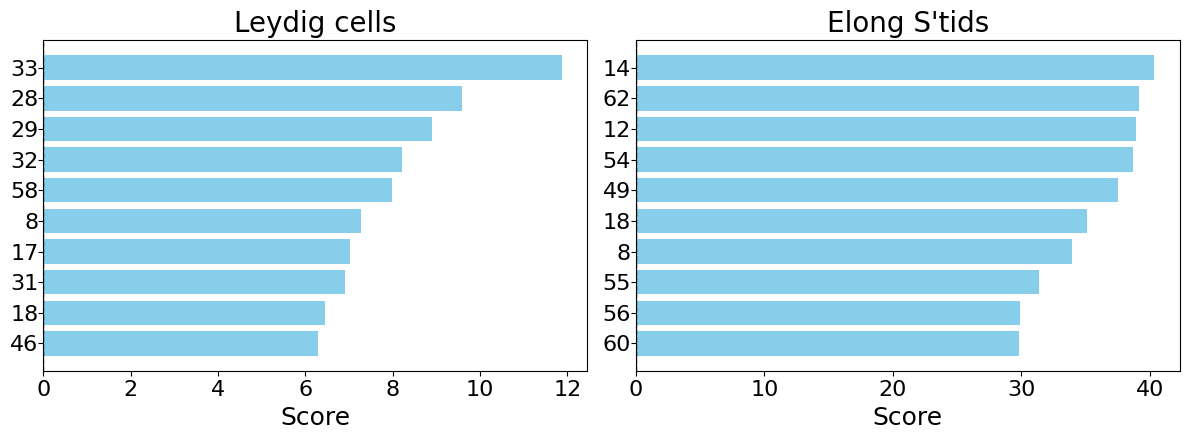

In [11]:
plot_rank_genes_as_bar(
    adata,
    key='rank_genes',
    groups=['Leydig cells', "Elong S'tids"],
    n_genes=10,
    sharey=False,
    fontsize=20,
    bar_height=0.8,
    y_spacing=0.05
)

### explain

In [12]:
import pickle
import numpy as np
import scanpy as sc
import pandas as pd

In [13]:
from NEXUS.model_int.SHAP_VAE.shap_explainer import classify_shap_gene_correlations_from_adata, generate_shap_importances, get_gene_list
from NEXUS.model_int.SHAP_VAE.shap_explainer import plot_shap_selected_genes, plot_enrich_show, plot_genes_box

In [14]:
adata = sc.read_h5ad('../test_data/3_SHAP_output/shap_adata.h5ad')
with open('../test_data/3_SHAP_output/shap_values.pickle', 'rb') as f:
    shap_values = pickle.load(f)

In [15]:
latent_idx = 14
leiden_sub = ['KS','OA','iNOA']
mask_donors = list(np.unique((adata[adata.obs['sample_cluster'].isin(leiden_sub)]).obs['sample_ID']))
mask = (adata.obs['sample_ID'].isin(mask_donors)) & (adata.obs["cell_type"] == "Elong S'tids")

In [16]:
adata_sub = adata[mask, :].copy()
shap_values_sub = shap_values[mask, :, :]

In [17]:
pos_genes, neg_genes = get_gene_list(adata_sub, shap_values_sub, latent_idx = latent_idx)

E:\NEXUS\NEXUS\model_int\SHAP_VAE\shap_explainer.py:47: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_sub,


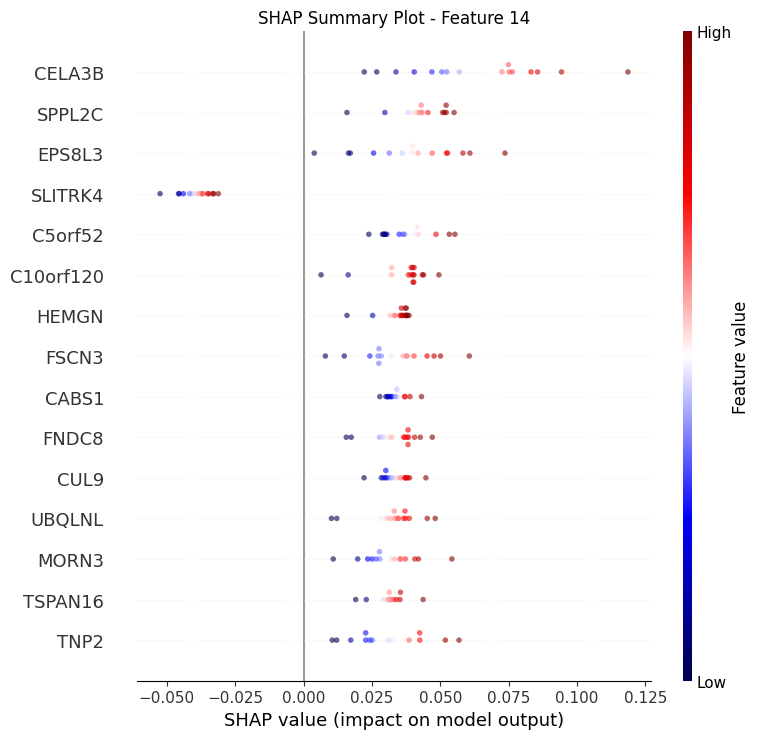

In [18]:
plot_shap_selected_genes(shap_values_sub, 
                         adata_sub, 
                         feature_num=latent_idx, 
                         selected_genes=pos_genes[:15])